# Question 2

This notebook is designed to outline the steps taken in the implementation of the 4-in-a-row game state detection algorithm. Intermediate steps are shown at the bottom of the notebook, with the final output presented first. 

In [15]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## Function Implementations 

Below is the modularised code used to detect the final output of the game state. 

In [16]:
##############################################################  FUNCTION IMPLEMENTATIONS ###################################################################################

"""
warp_image: condudcts a perspective transform and warp on an 
image to show just the game board

im: raw image

"""
def warp_image(im):

    # Convert image to HSV
    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # Interpret the colours in an HSV colour space
    H, S, V = cv2.split(im_hsv)

    # Define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) 

    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    # Find the largest external contour in the image, representing the game board 
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)


    # Extract the corners of the contour by fitting an approximated polygon to the contour
    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.02 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    # Order the corners to ensure corners are consistently detected
    ordered_corners = np.zeros((4, 2), dtype="float32")
    corners_sum = corners.sum(axis=1)
    corners_diff = np.diff(corners, axis=1)

    ordered_corners[0] = corners[np.argmin(corners_sum)]            # top-left
    ordered_corners[2] = corners[np.argmax(corners_sum)]            # bottom-right
    ordered_corners[1] = corners[np.argmin(corners_diff)]           # top-right
    ordered_corners[3] = corners[np.argmax(corners_diff)]           # bottom-left 

    # Arbitrary pixel range for the warped image
    h = 300
    w = 400
    
    # Setting array for output corners with consistent ordering
    corner_points_output = np.float32([
        [0, 0],                 # top-left
        [w - 1, 0],             # top-right
        [w - 1, h - 1],         # bottom-right
        [0, h - 1]              # bottom-left
    ])

    # Perform image transformation and warp
    M = cv2.getPerspectiveTransform(np.float32(ordered_corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return ordered_corners, warped_image

In [17]:
"""
find_game_state: determines the game state based on an input warped image

warped_image: [400x300] warped image

"""
def find_game_state(warped_image): 

    # Interpret the warped image in the HSV colour space
    warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)
    H1, S1, V1 = cv2.split(warped_hsv)


    # Define a bitwise or mask for the red mask
    lower1_red = (175,0,0)
    upper1_red = (200,255,255)

    lower2_red = (0,150,0)
    upper2_red = (10,255,255)

    mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
    mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

    red_mask = cv2.bitwise_or(mask1, mask2)


    # Define the yellow mask
    lower_yellow = (25,170,100)
    upper_yellow = (35,255,250)

    yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)


    # Perform morphological processes to filter out noise from the binary red mask 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)         # Morphological opening
    red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)      # Morphological closing

    #Apply contour to find edges of the board 
    red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Perform morphological processes to filter out noise from the binary yellow mask 
    yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
    yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Compute the statistics of the found contours for the red and yellow tokens
    (num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)
    (num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

    # Initialise array to store game state 
    game_state = np.zeros((6, 7))

    # Define consistent pixel ranges corresponding to rows and columns
    row_height = 50 
    col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

    # Assign each red token to a row/column 
    for i in range(1, num_components_red): 
        cx, cy = red_centroids[i]

        row_num = int(cy // row_height)                 # Each row is defined in increments of 50 from 0 to 300 --> Perform floor division to assign token to a row.

        # Assign token to a column using the pre-defined column list 
        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 2

    # Assign each yellow token to a row/column 
    for i in range(1, num_components_yellow): 
        cx, cy = yellow_centroids[i]

        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 1


    
    return game_state

In [18]:
# VERIFICATION FUNCTIONS

"""
find_board_accuracy: determines how many board cells are correctly labelled

validation_data: pickle file with ground truth board states 
image_path: path to the image being tested 

"""
def find_board_accuracy(validation_data, image_path):

    image = cv2.imread(image_path)
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Finding the relevant ground truth data in the pickle file
    image_label = os.path.basename(image_path)
    correct_array = validation_data[image_label]

    total_cells = 6*7

    # Warp image
    corners, warped_image = warp_image(im)

    # Find game state 
    game_state = find_game_state(warped_image)

    # Check how many cells are the same between ground truth and algorithm result
    num_correct = np.sum(correct_array == game_state)
    board_accuracy = num_correct/total_cells

    return board_accuracy


"""
find_overall_accuracies: returns the average and overall game accuracies 

validation_data: pickle file with ground truth board states 

"""
def find_overall_accuracies(validation_data): 

    counter = 0
    total_images = 15

    all_accuracies = []

    # Iterate through all images 
    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        # Calculate the individual board accuracy 
        board_accuracy = find_board_accuracy(validation_data, image_path)

        # Check if board has had all tokens correctly classified 
        if board_accuracy == 1: 
            counter += 1
        
        all_accuracies.append(board_accuracy)
    
    overall_accuracy = counter/total_images         # Percentage of boards with all tokens correctly classified 
    average_accuracy = np.mean(all_accuracies)      # Average board accuracy 

    return overall_accuracy, average_accuracy


"""
find_corner_accuracy: returns the corner accuracy of all boards 

validation_data: pickle file with ground truth corner states 

"""
def find_corner_accuracy(validation_data): 

    corner_accuracies = []

    # Iterate through all images
    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        image = cv2.imread(image_path)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract the corners returned by the corner detection
        corners, _ = warp_image(im)

        # Re-order corners to match corners in pickle data 
        temp = corners[2].copy()
        corners[2] = corners[3]
        corners[3] = temp

        true_corners = validation_data['%03d.jpg'%i]

        # Calculate the percentage error between the true corners and ground truth corners 
        error_norm = np.mean(np.linalg.norm(corners - true_corners, axis=1)/np.linalg.norm(true_corners, axis=1))

        # Turn error metric into an accuracy metric
        accuracy = 1-error_norm

        corner_accuracies.append(accuracy)

    # Take an average of the corner accuracies across all boards
    average_corner_accuracy = np.mean(corner_accuracies)

    return corner_accuracies, average_corner_accuracy

In order to run the algorithm on different boards, the path below can be changed. The following three code cells should then be run. It is noted that the verification functions run for approximately 1 minute as they iterate through and warp each image. 

Text(0.5, 1.0, 'Original Image')

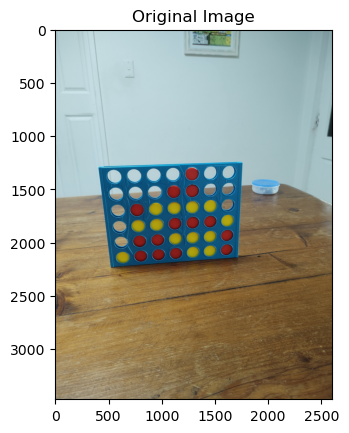

In [19]:
# Read in image
im_01 = cv2.imread('connect_four_images_A1/006.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

# Show original image
plt.imshow(im)
plt.title("Original Image")

[[0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0.]
 [0. 2. 1. 1. 1. 1. 0.]
 [0. 1. 1. 2. 2. 2. 1.]
 [0. 2. 2. 1. 1. 1. 2.]
 [1. 2. 2. 2. 1. 1. 2.]]


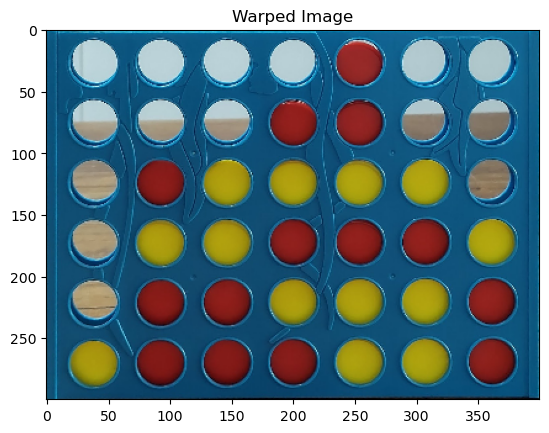

In [20]:

# Warp Image
_, warped_image = warp_image(im)
plt.imshow(warped_image)
plt.title("Warped Image")

# Determine Game State 
game_state = find_game_state(warped_image)
print(game_state)

In [21]:
# ACCURACY OF GAME STATE
with open('assign1Q2_validationdata/board_states.pkl', 'rb') as f:
        validation_data = pickle.load(f)

overall_accuracy, average_accuracy = find_overall_accuracies(validation_data)

print("Average accuracy: ", average_accuracy)
print("Overall accuracy: ", overall_accuracy)



# ACCURACY OF CORNER EXTRACTION
with open('assign1Q2_validationdata/board_corners.pkl', 'rb') as f:
        corner_data = pickle.load(f)

corner_accuracies, average_corner_accuracy = find_corner_accuracy(corner_data)
print("Average Corner Accuracy: ", average_corner_accuracy)


Average accuracy:  1.0
Overall accuracy:  1.0
Average Corner Accuracy:  0.9944211030984001


## Intermediate Steps for Code Implementation 

Below are the intermediate steps for the code implementation, highlighting all image colour thresholding and contour finding processes. The code below is not commented in detail. See the function implementations above for comments. 

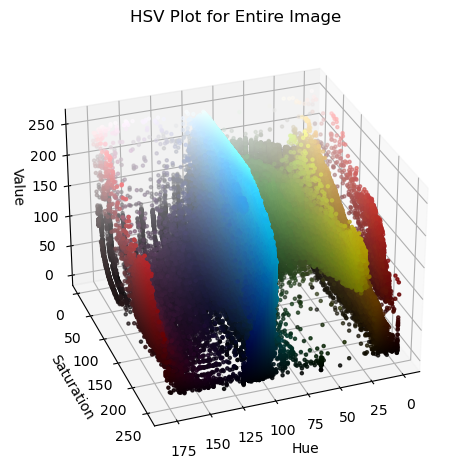

In [22]:


im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
norm = colors.Normalize(vmin=-1.0,vmax=1.0)
norm.autoscale(pixel_colours)
pixel_colours = norm(pixel_colours).tolist()

# visualise the colours in a RGB colour space
H, S, V = cv2.split(im_hsv)

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(H.flatten(), S.flatten(), V.flatten(), facecolors=pixel_colours, marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.set_title("HSV Plot for Entire Image")
axis.view_init(30,70) # (elevation, azimuth, roll): try adjusting to view from different perspectives

plt.tight_layout()



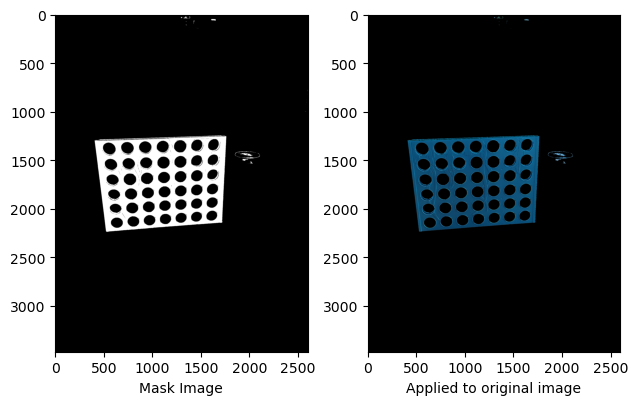

In [23]:
# Define a mask for the blue 

# define lower and upper ranges of HSV to extract blue board 
lower_hsv = (75,100,10)
upper_hsv = (105,255,220)

# Create mask of pixel inside range of lower and upper colours
mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

# Apply mask to visualise
im_thresh = im.copy()
im_thresh[(mask==0),:] = (0,0,0)
#im_temp = cv2.bitwise_and(im, im, mask=mask) # alternative way

# Display image and mask
plt.subplot(121)
plt.imshow(mask, 'gray')
plt.xlabel('Mask Image')

plt.subplot(122)
plt.imshow(im_thresh)
plt.xlabel('Applied to original image')

plt.tight_layout()

[[[1756 1253]]

 [[ 408 1297]]

 [[ 524 2231]]

 [[1714 2144]]]


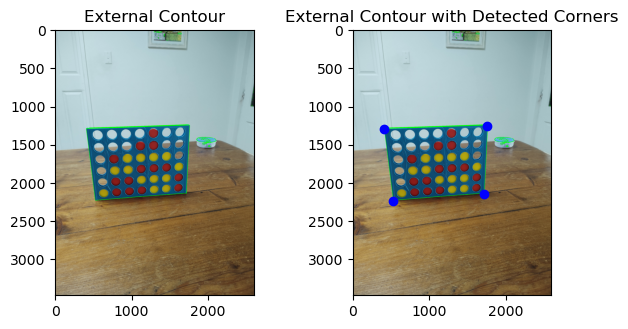

In [24]:
# Apply contour to find edges of the board 
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
im_contours = im.copy()
cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green


plt.subplots_adjust(wspace=0.5)  # Increase value for more space

plt.subplot(121)
plt.imshow(im_contours) # show the thresholded image
plt.title("External Contour")


arclength = cv2.arcLength(largest_contour, True)
epsilon = 0.02 * arclength 
approx_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
print(approx_corners)
approx_corners = approx_corners.reshape(-1, 2)

ordered_corners = np.zeros((4, 2), dtype="float32")
corners_sum = approx_corners.sum(axis=1)
corners_diff = np.diff(approx_corners, axis=1)

ordered_corners[0] = approx_corners[np.argmin(corners_sum)]      
ordered_corners[2] = approx_corners[np.argmax(corners_sum)]      
ordered_corners[1] = approx_corners[np.argmin(corners_diff)]    
ordered_corners[3] = approx_corners[np.argmax(corners_diff)]    


plt.subplot(122)
plt.imshow(im_contours) # show the thresholded image
plt.title("External Contour with Detected Corners")
x = ordered_corners[:,0]
y = ordered_corners[:,1]

plt.scatter(x, y, color='b')

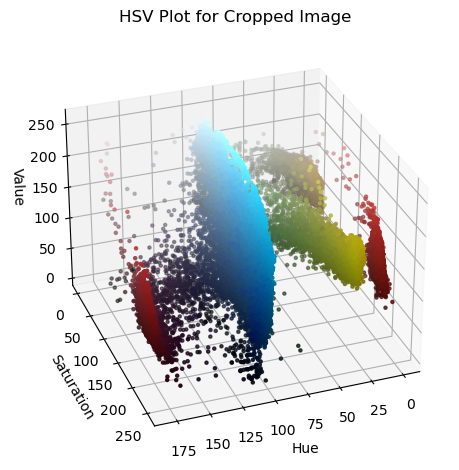

In [25]:
# contour red tokens and find centroid. then map centroid to a cell 

warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

H1, S1, V1 = cv2.split(warped_hsv)

pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
norm = colors.Normalize(vmin=-1.0,vmax=1.0)
norm.autoscale(pixel_colours)
pixel_colours = norm(pixel_colours).tolist()

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(H1.flatten(), S1.flatten(), V1.flatten(), facecolors=pixel_colours, marker='.')
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.set_title("HSV Plot for Cropped Image")
axis.view_init(30,70) # (elevation, azimuth, roll): try adjusting to view from different perspectives

plt.tight_layout()

# Red mask
lower1_red = (175,0,0)
upper1_red = (200,255,255)

lower2_red = (0,150,0)
upper2_red = (10,255,255)

mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

red_mask = cv2.bitwise_or(mask1, mask2)


# Yellow mask
lower_yellow = (25,170,100)
upper_yellow = (35,255,250)

yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

# # Apply mask to visualise
im_red = warped_image.copy()
im_red[(red_mask==0),:] = (0,0,0)

im_yellow = warped_image.copy()
im_yellow[(yellow_mask==0),:] = (0,0,0)



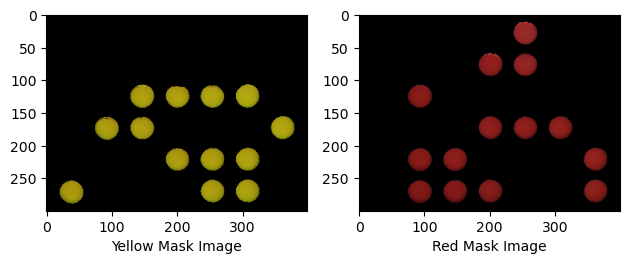

In [26]:
# Display image and mask
plt.subplot(121)
plt.imshow(im_yellow)
plt.xlabel('Yellow Mask Image')

plt.subplot(122)
plt.imshow(im_red)
plt.xlabel('Red Mask Image')

plt.tight_layout()

Num red 15
Num yellow 14


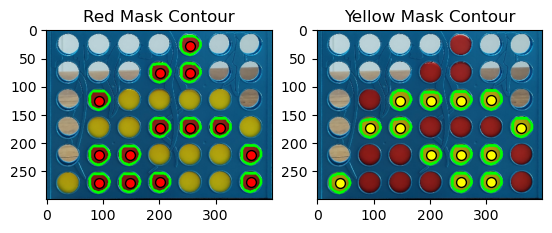

In [27]:
# Find centroids of red and yellow 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

 #Apply contour to find edges of the board 
red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

im_red_contours = warped_image.copy()
cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green

plt.subplot(121)
plt.imshow(im_red_contours) # show the thresholded image
plt.title("Red Mask Contour")

(num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

print("Num red", num_components_red)

for centroid in red_centroids[1:]:  # Skip the first element as it corresponds to the background
    plt.scatter(centroid[0], centroid[1], color='red', s=50, edgecolor='black', label="Red Centroid")



yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

im_yellow_contours = warped_image.copy()
cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

plt.subplot(122)
plt.imshow(im_yellow_contours) # show the thresholded image
plt.title("Yellow Mask Contour")


(num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

for centroid in yellow_centroids[1:]:  # Skip the first element as it corresponds to the background
    plt.scatter(centroid[0], centroid[1], color='yellow', s=50, edgecolor='black', label="Yellow Centroid")

print("Num yellow", num_components_yellow)

In [28]:
# Map centroids to a position 

game_state = np.zeros((6, 7))

row_height = 50 
col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

for i in range(1, num_components_red): 
    cx, cy = red_centroids[i]

    row_num = int(cy // row_height)

    for j in range(len(col_ranges) - 1): 
        if col_ranges[j] <= cx < col_ranges[j+1]:
            col_num = j

    game_state[row_num, col_num] = 2

for i in range(1, num_components_yellow): 
    cx, cy = yellow_centroids[i]


    row_num = int(cy // row_height)

    for j in range(len(col_ranges) - 1): 
        if col_ranges[j] <= cx < col_ranges[j+1]:
            col_num = j

    game_state[row_num, col_num] = 1

print(game_state)


[[0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0.]
 [0. 2. 1. 1. 1. 1. 0.]
 [0. 1. 1. 2. 2. 2. 1.]
 [0. 2. 2. 1. 1. 1. 2.]
 [1. 2. 2. 2. 1. 1. 2.]]
